```{admonition} Information
__Section__: Edge detection  
__Goal__: Understand that the quality of edge detection is highly related to the contrast of an image.  
__Time needed__: 20 min  
__Prerequisites__: Introduction about machine learning experiments, basics about image processing
```

# Edge detection

The contrast analysis through grayscale values can be verified with the use of edge detection algorithms. Without going into details about the algorithm itself, it is a tool that detects the edge of the objects in a picture, and can be useful for object detection or recognition tasks.

## Canny edge detection

The parameter ``sigma`` allows to control how detailed the detection of the edges should be. Try to change its value to see what happens.

```{toggle} Advanced level
We will use a model called [canny](https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html) with the function [canny()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.canny) of the ``skimage`` library.   
This function only works on black and white pictures, so we first need to transform the image in a grayscale.
```

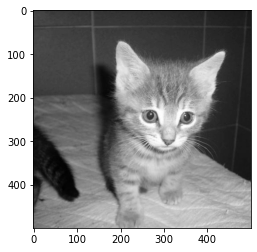

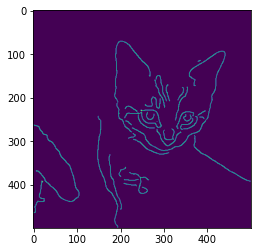

In [1]:
import matplotlib.pyplot as plt
import skimage.feature as sf
from skimage import io
from skimage.color import rgb2gray

image = rgb2gray(io.imread('./data/1.jpg'))
plt.imshow(image, cmap = 'gray')
plt.show()
canny = sf.canny(image, sigma = 3)
plt.imshow(canny)

In [2]:
# beginner version

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def plot_canny(sigma):
    image = rgb2gray(io.imread('./data/1.jpg'))
    plt.imshow(image, cmap = 'gray')
    plt.show()
    canny = sf.canny(image, sigma = sigma)
    plt.imshow(canny)

    
interact(plot_canny,
         sigma = widgets.FloatText(value = 3.0,
                                    description = 'sigma = ',
                                    disabled = False))

interactive(children=(FloatText(value=3.0, description='sigma = '), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_canny(sigma)>

This function is connected with contrast: the detected edges are the result of a high change of gray value between two areas. A picture where the object is highly contrasted with the background will yield better results with the edge detection algorithm. to figure it out, compare in the following cell different pictures, by changing the name ``1.jpg`` with different integers in the range ``[1, 20]``. Change also the sigma value when it is needed to better gauge the edge detection result.

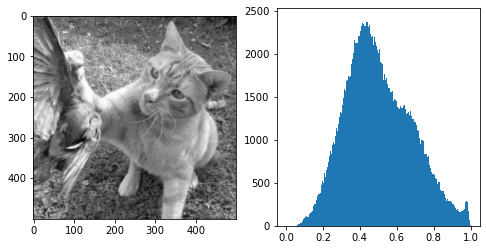

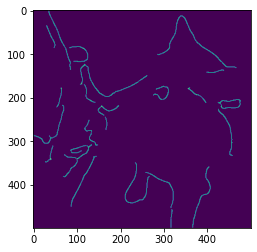

In [3]:
image = rgb2gray(io.imread('./data/5.jpg'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
ax1.imshow(image, cmap = 'gray')
ax2.hist(image.flatten(), bins = 256, range = (0, 1))
plt.show()
canny = sf.canny(image, sigma = 5)
plt.imshow(canny)

In [4]:
# For beginner version: cell to hide

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def plot_general(image_nb, sigma):
    image = rgb2gray(io.imread('./data/' + str(image_nb) + '.jpg'))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
    ax1.imshow(image, cmap = 'gray')
    ax2.hist(image.flatten(), bins = 256, range = (0, 1))
    plt.show()
    canny = sf.canny(image, sigma = sigma)
    plt.imshow(canny)

    
interact(plot_general,
         image_nb = widgets.IntText(value = 1,
                                    description = 'Image:',
                                    disabled = False),
         sigma = widgets.FloatText(value = 3.0,
                                    description = 'sigma = ',
                                    disabled = False))

interactive(children=(IntText(value=1, description='Image:'), FloatText(value=3.0, description='sigma = '), Ou…

<function __main__.plot_general(image_nb, sigma)>

We notice that the pictures with a better edge detection work (where the animal is well detected) are also the ones with a better contrast.

## HOG from canny picture

We see that we can get an idea on how to gauge the quality of the image itself. But to be sure that it will enhance our personal model, we need to apply our method (HOG descriptors) to the generated image.

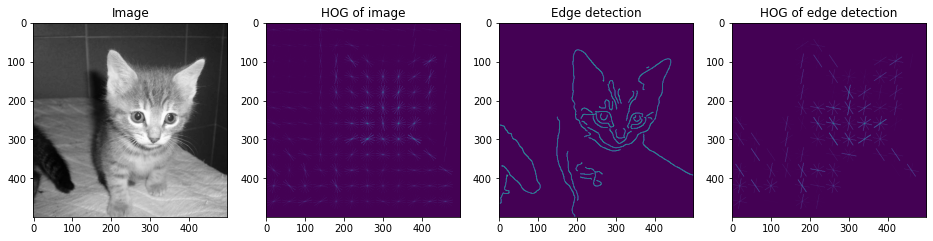

In [5]:
from skimage.exposure import rescale_intensity
from skimage.feature import hog

image = rgb2gray(io.imread('./data/1.jpg'))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))

ax1.imshow(image, cmap = 'gray')
ax1.set_title('Image')

fd, hog_image = hog(image, orientations = 8, pixels_per_cell = (40, 40), visualize = True)
hog_image_rescaled = rescale_intensity(hog_image, in_range = (0, 10))
ax2.imshow(hog_image_rescaled)
ax2.set_title('HOG of image')

canny = sf.canny(image, sigma = 3)
ax3.imshow(canny)
ax3.set_title('Edge detection')

fd, hog_image = hog(canny.astype(int), orientations = 8, pixels_per_cell = (40, 40), visualize = True)
hog_image_rescaled = rescale_intensity(hog_image, in_range = (0, 10))
ax4.imshow(hog_image_rescaled)
ax4.set_title('HOG of edge detection')

plt.show()

From the previous graphs, we can see that the image of a cat is better recognizable from the HOG descriptors of the edge detected picture than from the original picture. We can now launch the classification task to see if it impacts the algorithm itself.

First, we build the model and predict from the original image, using the functions we defined previously. Then, we transform the images to their canny equivalent and use those HOG features for the prediction.

We can try different classifications (with different training and testing sets) by changing the value for the parameter ``random_state``.

Accuracy: 0.5


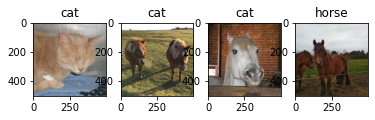

In [26]:
# Run on classic images

%run 2-functions.ipynb

import pandas as pd
from sklearn.metrics import accuracy_score

# Read dataset
images = read_images('./2-images.csv')

# Create HOG features
images = images.assign(hog_features = create_hog(images['image']))

# Build the model and return predictions
pred, y_test, test = classify_images(images, random_state = 3)

# Compute and print the accuracy
print('Accuracy: ' + str(accuracy_score(pred, y_test)))

# Print the test images and the predictions
print_results(pred, test)

Accuracy: 0.25


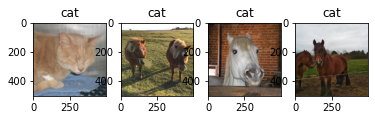

In [50]:
# Run on canny edge detection

%run 2-functions.ipynb

import skimage.feature as sf
from skimage.color import rgb2gray

images = read_images('./2-images.csv')

# Create canny image for each image
canny_list = []
for index, row in images.iterrows():
    canny_list.append(sf.canny(rgb2gray(row['image']), sigma = 3))

# Save canny in the images DataFrame
images = images.assign(canny = canny_list)

# Get the HOG features from the canny image
images = images.assign(hog_features = create_hog(images['canny'], canny = True))

# Classify and get the results
pred, y_test, test = classify_images(images, random_state = 3)
print('Accuracy: ' + str(accuracy_score(pred, y_test)))
print_results(pred, test)

In [52]:
# Beginner version: cell to hide

import ipywidgets as widgets
from ipywidgets import interact

def compare_canny(random_state):
    
    %run 2-functions.ipynb

    import pandas as pd
    from sklearn.metrics import accuracy_score
    import skimage.feature as sf
    from skimage.color import rgb2gray

    images = read_images('./2-images.csv')

    images = images.assign(hog_features = create_hog(images['image']))
    pred, y_test, test = classify_images(images, random_state = random_state)
    print('Accuracy with normal images: ' + str(accuracy_score(pred, y_test)))
    print_results(pred, test)
    
    canny_list = []
    for index, row in images.iterrows():
        canny_list.append(sf.canny(rgb2gray(row['image']), sigma = 3))
    images = images.assign(canny = canny_list)
    images = images.assign(hog_features = create_hog(images['canny'], canny = True))
    pred, y_test, test = classify_images(images, random_state)
    print('Accuracy with canny transformation: ' + str(accuracy_score(pred, y_test)))
    print_results(pred, test)

interact(compare_canny, random_state = widgets.IntText(
    value = 3,
    description = 'random_state:',
    disabled = False
))

interactive(children=(IntText(value=3, description='random_state:'), Output()), _dom_classes=('widget-interact…

<function __main__.compare_canny(random_state)>

Note that the size of the dataset we use is really small (20 images) and that is why the result of the changes we make might not be obvious. Trying with a bigger dataset might show better results, but the models would be too long to run in this course.

## Quiz

In [1]:
from IPython.display import IFrame
IFrame("https://blog.hoou.de/wp-admin/admin-ajax.php?action=h5p_embed&id=69", "959", "309")